In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import cholesky, sqrtm
from scipy.optimize import minimize
from scipy.stats import chi2, norm

In [2]:
# Mock result
data = np.array([5, 3])
cor = 0.95
err = np.array([1.5,1.])
cov = np.diag(err**2)
cov[1,0] = cov[0,1] = err[0]*err[1] * cor
cov_inv = np.linalg.inv(cov)
err = np.sqrt(np.diag(cov))

In [3]:
# Regularisation
#
# \Delta \chi^2 = x^T C x
#
N = 2

# Penalise large values
C_0 = np.eye(N)

# Penalise bin diffrences
# chi = sum_i( (x_i - x_{i+1})^2 )
C_1 = np.diag([1] + [2] * (N - 2) + [1], k=0) + np.diag([-2] * (N - 1), k=1)

C = C_1
# Make symmetric
C = (C + C.T) / 2
print(np.linalg.det(C))

0.0


In [4]:
# Regularised result
#
# m' = A m
# A = (cov^{-1} + C)^-1 cov^{-1}

tau_list = [0.0] + list(np.logspace(-2, 1, 25))
A_list = [np.linalg.inv(cov_inv + tau * C) @ cov_inv for tau in tau_list]
regularised_list = [A @ data for A in A_list]

In [5]:
# Alt metrics
# Determinant of covariance/correlation matrix as measure of overall correlation?
cov_list = [A @ cov @ A.T for A in A_list]
cor_list = [
    np.diag(np.diag(c) ** (-0.5)) @ c @ np.diag(np.diag(c) ** (-0.5)) for c in cov_list
]
cov_det_list = [np.linalg.det(c) for c in cov_list]
cor_det_list = [np.linalg.det(c) for c in cor_list]

In [6]:
# Alt metrics
# Wasserstein distance in uncorrelated standard normal space
# The Fréchet distance between multivariate normal distributions
# https://doi.org/10.1016/0047-259X(82)90077-X
U = cholesky(cov_inv)
dist = []
diag_dist = []
m = U @ data


def wasserstein(x, cov):
    diff = m - U @ x
    S = U @ cov @ U.T
    d = diff.T @ diff + cov.shape[0] + np.trace(S - 2 * sqrtm(S))
    return abs(d)  # Catch some numerical issues


for x, c in zip(regularised_list, cov_list):
    # Distance between original and regularised
    dist.append(wasserstein(x, c))
    # Distance between original and plot
    diag_dist.append(wasserstein(x, np.diag(np.diag(c))))

8.043008892167197


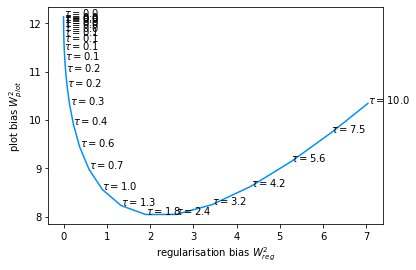

In [7]:
plt.plot(dist, diag_dist)
plt.xlabel("regularisation bias $W^2_{reg}$")
plt.ylabel("plot bias $W^2_{plot}$")
i_W = 0
best = np.inf
for i, (x, y, tau) in enumerate(zip(dist, diag_dist, tau_list)):
    plt.annotate(fr"$\tau = {tau:.1f}$", (x, y))
    if y < best:
        best = y
        i_W = i
print(best)

[4.14271581 3.55836875]


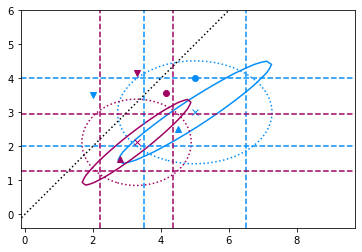

In [8]:
# Data point
plt.plot([data[0]], [data[1]], marker="x", color="C0")

sigmas = 1

# True CI
x = np.linspace(data[0] - 3 * err[0], data[0] + 3 * err[0], 50)
y = np.linspace(data[1] - 3 * err[1], data[1] + 3 * err[1], 50)
xx, yy = np.meshgrid(x, y)
xy = np.stack((xx, yy), axis=-1)[..., None]
xyT = xy.transpose((0, 1, 3, 2))
zz = (xyT - data[None, :]) @ cov_inv @ (xy - data[:, None])
plt.contour(
    xx, yy, zz.squeeze(), levels=[chi2(2).ppf(chi2(1).cdf(sigmas ** 2))], colors=["C0"]
)

# Implied uncorrelated CI
zz = (xyT - data[None, :]) @ np.diag(1.0 / (np.diag(cov))) @ (xy - data[:, None])
plt.contour(
    xx,
    yy,
    zz.squeeze(),
    levels=[chi2(2).ppf(chi2(1).cdf(sigmas ** 2))],
    colors=["C0"],
    linestyles="dotted",
)

# Visible error bars
plt.axvline(data[0] - sigmas * err[0], color="C0", linestyle="dashed")
plt.axvline(data[0] + sigmas * err[0], color="C0", linestyle="dashed")
plt.axhline(data[1] - sigmas * err[1], color="C0", linestyle="dashed")
plt.axhline(data[1] + sigmas * err[1], color="C0", linestyle="dashed")

# Regularised data
reg_data =regularised_list[i_W] 
plt.plot([reg_data[0]], [reg_data[1]], marker="x", color="C2")

# True CI
reg_cov = cov_list[i_W]
reg_cov_inv = np.linalg.inv(reg_cov)
reg_err = np.sqrt(np.diag(reg_cov))
x = np.linspace(reg_data[0] - 3 * reg_err[0], reg_data[0] + 3 * reg_err[0], 50)
y = np.linspace(reg_data[1] - 3 * reg_err[1], reg_data[1] + 3 * reg_err[1], 50)
xx, yy = np.meshgrid(x, y)
xy = np.stack((xx, yy), axis=-1)[..., None]
xyT = xy.transpose((0, 1, 3, 2))
zz = (xyT - reg_data[None, :]) @ reg_cov_inv @ (xy - reg_data[:, None])
plt.contour(
    xx, yy, zz.squeeze(), levels=[chi2(2).ppf(chi2(1).cdf(sigmas ** 2))], colors=["C2"]
)

# Implied uncorrelated CI
zz = (xyT - reg_data[None, :]) @ np.diag(1.0 / (np.diag(reg_cov))) @ (xy - reg_data[:, None])
plt.contour(
    xx,
    yy,
    zz.squeeze(),
    levels=[chi2(2).ppf(chi2(1).cdf(sigmas ** 2))],
    colors=["C2"],
    linestyles="dotted",
)

# Visible error bars
plt.axvline(reg_data[0] - sigmas * reg_err[0], color="C2", linestyle="dashed")
plt.axvline(reg_data[0] + sigmas * reg_err[0], color="C2", linestyle="dashed")
plt.axhline(reg_data[1] - sigmas * reg_err[1], color="C2", linestyle="dashed")
plt.axhline(reg_data[1] + sigmas * reg_err[1], color="C2", linestyle="dashed")

# Some models
A = A_list[i_W]
model = [4.5, 2.5]
reg_model = A @ model
plt.plot([model[0]], [model[1]], color="C0", marker="^")
plt.plot([reg_model[0]], [reg_model[1]], color="C2", marker="^")

model = [2, 3.5]
reg_model = A @ model
plt.plot([model[0]], [model[1]], color="C0", marker="v")
plt.plot([reg_model[0]], [reg_model[1]], color="C2", marker="v")

model = [5, 4]
reg_model = A @ model
print(reg_model)
plt.plot([model[0]], [model[1]], color="C0", marker="o")
plt.plot([reg_model[0]], [reg_model[1]], color="C2", marker="o")

plt.axis("equal")

# Orientation
plt.plot([-10,10], [-10,10], color="k", linestyle="dotted", scalex=False, scaley=False)

In [9]:
print(cor_list[i_W])

[[1.         0.95163454]
 [0.95163454 1.        ]]
